# Creating A Computation Graph in python

Ordinarily when you write an expression such as "a*(b+c)" in python, we think that expression will evaluate to a number.  Or if the inputs are vectors or tensors, we think that the value will be a vector or tensor.

But when you write expressions using pytorch tensors with `requires_grad=True`, they can produce a *graph* of computation nodes instead of just a tensor. The graph will look like the image below.

In this notebook, we will show how to use python *operator overloading* to create computation graphs like that.

We will define the following classes:
* `ComputationNode`, a base class for all the node (circles)
* A `Leaf` subclass for the starting nodes like "a" and "b"
* An `Sub` subclass for representing the "-" operation
* A `Mul` subclass for representing the "*" operation

The computation graph is useful because you can use it to implement *backpropagation* to get derivatives.  We will not do that yet today, but today we will implement the *forward_pass* algorithm for evaluating a computation graph and getting the answer.

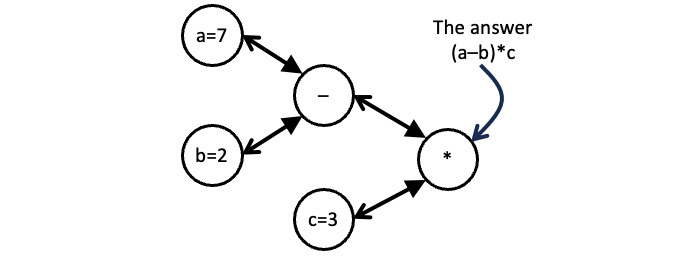

## Step 1.  Define the constructor for ComputationNode

The point of a ComputationNode is to carry pointers to the rest of the computaiton graph.  To set this up, create the constructor so that:

1. The `__init__` method is passed a list of "children nodes" that will represent the inputs to the computation
2. The node saves a list of these inputs as `self.input_nodes`.
3. Every node in the list should also be a `ComputationNode` or a subclass. If it is not (e.g., if just a number or a vector) then we construct a `Leaf` subclass of `ComputationNode` to wrap the object in a node.


This can all be done with the following constructor code.  It also includes an optional name that we can use to label a node.


```
# TODO: copy this constructor into the class definition below.
class ComputationNode:
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n)
            for n in input_nodes]
```

**TODO:** Copy the code for the `ComputationNode` constructor into **main class definition** cell in the implementation below.  The implementation below also has a fancy little recursive printing method that you can leave as-is.


In [ ]:
# The main class definition cell.  TODO: you will write all your code in here.

class ComputationNode:
    def __init__(self, *input_nodes, name=None):
        self.name = name
        # TODO: Copy the code from above.
        self.input_nodes = []

    # Later here you will also define several new methods here including:
    #
    # def __sub__(self, other):
    # and
    # def __mul__(self, other):
    # and
    # def sorted_nodes(self, seen=None):

    # Predefine a recursive print-out that makes recursive indented outputs.
    def __repr__(self):
        return self.tree_repr({})
    def tree_repr(self, seen):
        '''Print out the node and its inputs recursively so you can see the graph.'''
        if self in seen: return seen[self]
        seen[self] = (f'{type(self).__name__}#{len(seen) + 1}' +
               ''.join(f', {a}={getattr(self, a)}' for a in vars(self)
                  if '_' not in a and getattr(self, a) is not None))
        return '\n  '.join('\n'.join([seen[self]] +
             [node.tree_repr(seen) for node in self.input_nodes]).split('\n'))


#class Leaf(ComputationNode):
#    pass # Later you will define this

#class Sub(ComputationNode):
#    pass # Later you will define this

#class Mul(ComputationNode):
#    pass # Later you will define this

## Seeing the ComputationNode graph

Run the code below.

Make sure the ComputationNode prints out as several lines.

Then answer the following questions.

1. Is the computation node graph a **tree** or some other sort of graph?
2. **How many** distinct ComputationNodes are in the graph?
3. **Draw the graph**, with a thin arrow from each node to each of its input nodes.
4. To understand the direction of the data flow, draw **dark arrow heads in the opposite direction** over all the arrows.

In [ ]:
# TODO: for this to work, you will need to define the ComputationNode constructor above.

a = ComputationNode(name='a')
b = ComputationNode(name='b')
c = ComputationNode(name='c')

root = ComputationNode(a, ComputationNode(b, c), b, a)

print(root)

A `ComputationNode` will automatically wrap regular input in a `Leaf` node.  So we need to define the `Leaf` subclass of `ComputationNode` that actually holds something.

That's easy: a `Leaf` just stores a value, and has no other input nodes below it.

**TODO:** To define a `Leaf` class, copy the code below to complete the incomplete class definition for `Leaf` in the appropriate cell above.

```
## TODO: copy this constructor into the main class definition cell
class Leaf(ComputationNode):
    def __init__(self, value, name=None):
        super().__init__(name=name)
        self.value = value
```



Now if you make a `ComputationNode(7, 2, 3)` with ordinary numeric inputs 7, 2, 3, it will automatically wrap each of the input values in `Leaf` nodes.  Try it here:

In [ ]:
# TODO: for this to work, you will need to define the Leaf class above.
ComputationNode(7, 2, 3)

## The Main Trick: Operator Overloading

Now what we'd really like to do is to define a few named `Leaf` nodes to represent variables, like `a = Leaf(7, name='a')` and then we would like to be able to write expressions like `(a-b)*c` to get a whole computation graph.

Here is the code we would like to work.  Try running it below - it will produce an error at first.

In [ ]:
# Don't worry that this produces an error at first.  We will fix it in later steps.
a = Leaf(7, name='a')
b = Leaf(2, name='b')
c = Leaf(3, name='c')

root = (a-b)*c

print(root)

Notice the error message: `TypeError: unsupported operand type(s) for -: 'Leaf' and 'Leaf'`.  Python is complaining that it only knows how to use `-` for things like numbers, and it doesn't know how to do `-` for `Leaf` objects like `a` or `b`.

We can fix that by defining a special *operator overloading method* on the `Leaf` class or its base class.

## How to do operator overloading

Here is how operator overloading works in python.

There are several special method names that python allows you to define in order to show how operators should work on a particular class.  All the special method names begin and end with a double-underscore.  Some of the special operator-overloading method names are listed below.

 Special method name | operator
:-------------------:|:--------:
 `__add__`           |  x + y
 `__sub__`           |  x - y
 `__mul__`           |  x * y
 `__div__`           |  x / y
 `__pow__`           |  x ** y
 `__neg__`           |  - x

To define how to subtract things from `ComputationNode` objects using the infix `-` operator, you will add a `__sub__` method to the `ComputationNode` class, like this:

```
    # TODO: copy this method definition into the main class definition cell above
    def __sub__(self, other):
        return Sub(self, other)
```

```
# TODO: copy this class definition in the main class definition cell above
class Sub(ComputationNode):
    def __init__(self, x, y, name=None):
        super().__init__(x, y, name=name)
```

In our case, in this method definition, we are combining two graphs.  So we will not want the `-` operation to subtract one graph from another; instead, we want to create a new `ComputationNode` (we will make a `Sub` subclass), and connect that new node to the graph by hooking it up to the two input children nodes.  The result will be a bigger graph.

**TODO:** Try it out by following the next three steps.

  1. Add the `__sub__` method to your `ComputationNode` base class definition above.
  2. Define a `Sub` subclass of `ComputationNode` below (we have defined it for you, just copy it).
  3. Execute a-b below.

It should work!

It should give you a graph with three nodes.

In [ ]:
# TODO: for this to work, you need to define the Leaf and Sub classes above
# and you will also need to define the __sub__ method on ComputationNode.

a = Leaf(7, name='a')
b = Leaf(2, name='b')

print(a-b)

NameError: name 'Leaf' is not defined

## Defining `*` with `__mul__`

Now if you try to evaluate `(a-b)*b` it will give you a new error:

```TypeError: unsupported operand type(s) for *: 'Sub' and 'Leaf'```

To fix this, we will next need to specify how to overload `*` - again, we will want to define it to create a new node and make the graph bigger.

**TODO:** Do this on your own:

 1. Define a `__mul__` method on the base `ComputationNode` class.
 2. Create a `Mul` subclass to represent the new kind of computation node.
 3. The verify that `(a-b)*c` works.



In [ ]:
# TODO: for this to work, you will need to define Mul, Sub, and Leaf classes
# and you also need __mul__ and __sub__ methods on ComputationNode

a = Leaf(7, name='a')
b = Leaf(2, name='b')
c = Leaf(3, name='c')

root = (a-b)*c

print(root)

## How to Sort the Nodes of an Directed Acyclic Graph

Once you have a computation graph, you can do basic graph operations on it.  One of the most important and useful operations is to create a **toplogical sort** of all the nodes.

A toplogical sort is a sorting of nodes in some order

$$[ n_1, n_2, ..., n_i, ... n_m]$$

So that whenever there is a directed path from $n_i$ to $n_j$ within the graph, the list has $i < j$, i.e., $n_i$ comes before $n_j$ in the sort order.

The standard algorithm to do a toplogical sort is to start at the root and do a **depth-first-traversal** of the graph, while maintaining a set of nodes already seen, and using that set to skip already-visited nodes so that we never re-visit the same node twice.

**TODO:** Here is a python implementation of a topological sort as a method `sorted_nodes` that can be added to `ComputationNode`.  Read it and undertand it, then copy it to the cell above that defines the base class.

```
    # TODO: copy this into the main class definition above
    def sorted_nodes(self, seen=None, result=None):
        if seen is None: seen, result = set(), []
        if self in seen: return result
        seen.add(self)
        for node in self.input_nodes:
            node.sorted_nodes(seen, result)
        result.append(self)
        return result
```



In [ ]:
# TODO: for this to work, you will need to define Mul, Sub, and Leaf classes
# and you also need __mul__ and __sub__ methods on ComputationNode

a = Leaf(7, name='a')
b = Leaf(2, name='b')
c = Leaf(3, name='c')

root = (a-b)*c

for i, n in enumerate(root.sorted_nodes()):
    print(f'sorted_nodes[{i}]:\n{n}\n')

sorted_nodes[0]:
Mul#1
  Sub#2
    Leaf#3, name=a, value=7
    Leaf#4, name=b, value=2
  Leaf#5, name=c, value=3

sorted_nodes[1]:
Sub#1
  Leaf#2, name=a, value=7
  Leaf#3, name=b, value=2

sorted_nodes[2]:
Leaf#1, name=a, value=7

sorted_nodes[3]:
Leaf#1, name=b, value=2

sorted_nodes[4]:
Leaf#1, name=c, value=3



# Evaluating a Computation Graph: Forward Pass

So far we have built a computation graph without actually doing the computation.

To actually ge the answer of `(a-b)*c` we need to *evaluate* the graph.  We'll call this algorithm the *forward pass* through the graph (since we will later do a second *backward pass* to get derivatives).

Here is how the forward pass will work:
  * For each node type, we will define a `forward(self)` method that has the job of evaluates the calculation in the node and then putting the answer into the field `self.result`.  The `forward` node will assume that the input nodes (if any) have already been evaluated.
  * The `forward()` methods need to be called in the proper order.
  * We will later write a special `forward_algorithm` function to call all the `forward` methods in the correct order automatically.

## First: Paste in `forward()` methods for `Leaf` and `Sub`

The code for `forward` methods for `Leaf` and `Sub` classes are listed below.  Find the class definitions above and paste them in

```
class Leaf(ComputationNode):
    def __init__(self, value, name=None):
        super().__init__(name=name)
        self.value = value
    def forward(self):
        self.result = self.value

class Sub(ComputationNode):
    def __init__(self, x, y, name=None):
        super().__init__(x, y, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result - self.input_nodes[1].result
```

Then you can run a forward pass "manually" by running the cell below.



In [ ]:
a = Leaf(7, name='a')
b = Leaf(2, name='b')
diff = (a-b)

print(diff, '\n')
a.forward()
print(diff, '\n')
b.forward()
print(diff, '\n')
diff.forward()
print(diff, '\n')

In [ ]:
print(Sub.forward)

## Second: define the `forward` for the `Mul` class on your own.

Add `forward` to the `Mul` class so that the following code runs.

In [ ]:
a = Leaf(7, name='a')
b = Leaf(2, name='b')
c = Leaf(3, name='c')
diff = (a-b)
root = diff*c

print(root, '\n')
a.forward()
print(root, '\n')
b.forward()
print(root, '\n')
diff.forward()
print(root, '\n')
c.forward()
print(root, '\n')
root.forward()
print(root, '\n')


## Finally: write the forward pass

Write a `forward_pass` function that automatically runs the forward pass using a loop.

Hint: do not use recursion directly. Instead, use the `sorted_nodes` method of the computation graph.

In [ ]:
def forward_pass(root):
    node_list = [] ## TODO: what sort order do you need?
    for node in node_list:
        print(root, '\n') # TODO: remove this later to make the function quieter
        node.forward()
    return root.result

a = Leaf(7, name='a')
b = Leaf(2, name='b')
c = Leaf(3, name='c')
root = (a-b)*c
forward_pass(root)
print(root)

### Warning!

In homework 2, the `sorted_nodes` method that is given within the homework is different from the one here, because instead of doing a pre-order traversal of the graph it does a post-order traversal, which creates the opposite sort order.

Therefore, when doing homework 2, your use of `sorted_nodes` will need to be reversed from the way you have used it here.

In the next class we will look at the backward pass.

In [ ]:
# For your reference: fullly-worked answers below.

class ComputationNode:
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n) for n in input_nodes]
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n)
            for n in input_nodes]

    def __sub__(self, other):
        return Sub(self, other)

    def __mul__(self, other):
        return Mul(self, other)

    def sorted_nodes(self, seen=None):
        if seen is None: seen = []
        if self in seen: return seen
        seen.append(self)
        for node in self.input_nodes:
            node.sorted_nodes(seen)
        return seen

    # Predefine a recursive print-out that makes recursive indented outputs.
    def __repr__(self):
        return self.tree_repr({})
    def tree_repr(self, seen):
        '''Print out the node and its inputs recursively so you can see the graph.'''
        if self in seen: return seen[self]
        seen[self] = (f'{type(self).__name__}#{len(seen) + 1}' +
               ''.join(f', {a}={getattr(self, a)}' for a in vars(self)
                  if '_' not in a and getattr(self, a) is not None))
        return '\n  '.join('\n'.join([seen[self]] +
             [node.tree_repr(seen) for node in self.input_nodes]).split('\n'))


class Leaf(ComputationNode):
    def __init__(self, value, name=None):
        super().__init__(name=name)
        self.value = value
    def forward(self):
        self.result = self.value

class Sub(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result - self.input_nodes[1].result

class Mul(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result * self.input_nodes[1].result

def forward_pass(root):
    node_list = reversed(root.sorted_nodes())
    for node in node_list:
        print(root, '\n') # TODO: remove this later to make the function quieter
        node.forward()
    return root.result

a = Leaf(7, name='a')
b = Leaf(2, name='b')
c = Leaf(3, name='c')
root = (a-b)*c
forward_pass(root)
print(root, '\n')

print(f'The answer to (a-b)*c is {root.result}')